<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Often necessary b/c pandas & statsmodels datetime issue
#import warnings
#warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [51]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [52]:
walmart.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

**Creating a datetime index**

Convert the Date column to datetime, and set it as the index for the dataframe.

In [53]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [54]:
walmart.set_index('Date', inplace =True)
walmart.sort_index(inplace = True)

**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **[groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [55]:
walmart_first_store = walmart[walmart['Store']==1][['Weekly_Sales']]
walmart_first_store.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-05,11501.46
2010-02-05,814.00
2010-02-05,70.00
2010-02-05,1.16


In [56]:
walmart_first_store = walmart_first_store.groupby(by = walmart_first_store.index).sum()
walmart_first_store.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

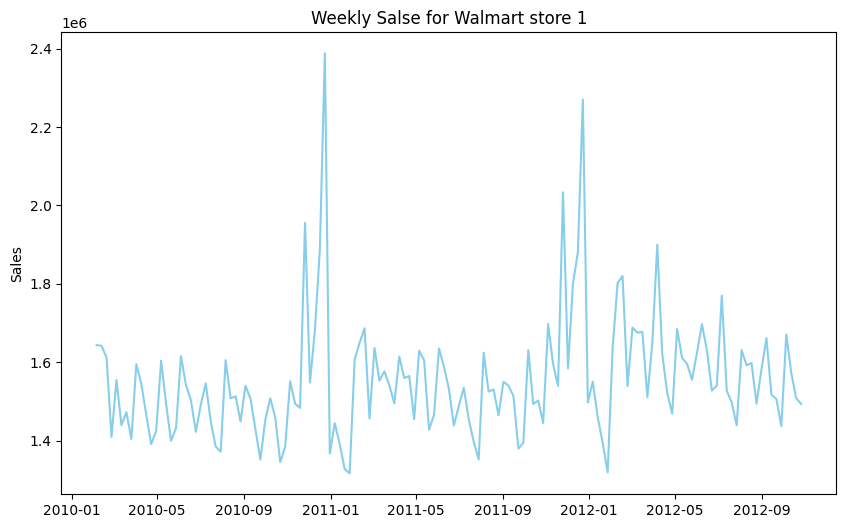

In [57]:
plt.figure(figsize=(10,6))
plt.plot(walmart_first_store, color = 'skyblue', label = 'Weekly Sales')
plt.title('Weekly Salse for Walmart store 1')
plt.ylabel('Sales')
plt.show()

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

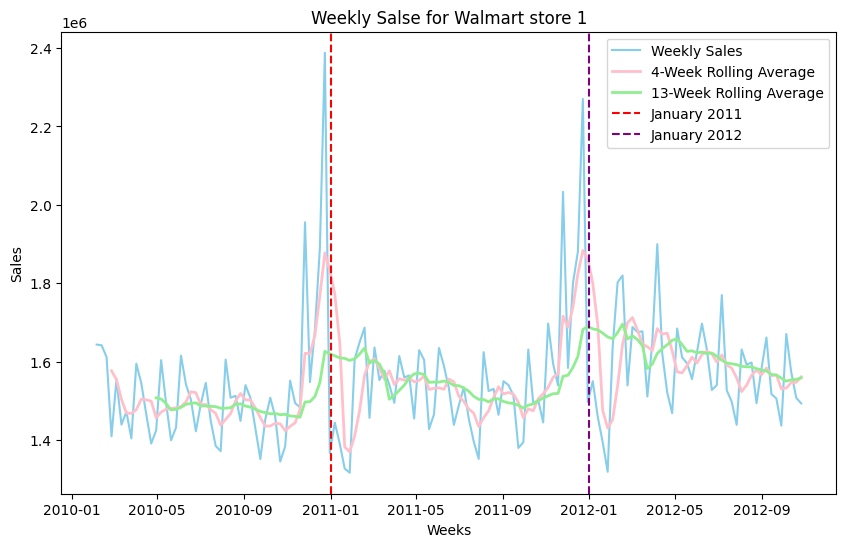

In [58]:
week_avg = walmart_first_store
four_week_avg = walmart_first_store.rolling(window=4).mean()
thirteen_week_avg = walmart_first_store.rolling(window=13).mean()

plt.figure(figsize=(10, 6))
plt.plot(week_avg, color='skyblue', label='Weekly Sales')
plt.plot(four_week_avg, color='pink', label='4-Week Rolling Average', linewidth=2)
plt.plot(thirteen_week_avg, color='lightgreen', label='13-Week Rolling Average', linewidth=2)

plt.axvline(x=pd.to_datetime('2011-01-01'), color='red', linestyle='--', label='January 2011')
plt.axvline(x=pd.to_datetime('2012-01-01'), color='purple', linestyle='--', label='January 2012')

plt.title('Weekly Salse for Walmart store 1')
plt.ylabel('Sales')
plt.xlabel('Weeks')

plt.legend()

plt.show()

**Describe any trends that you notice**

In [59]:
# A: This grapt show yearly trends.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

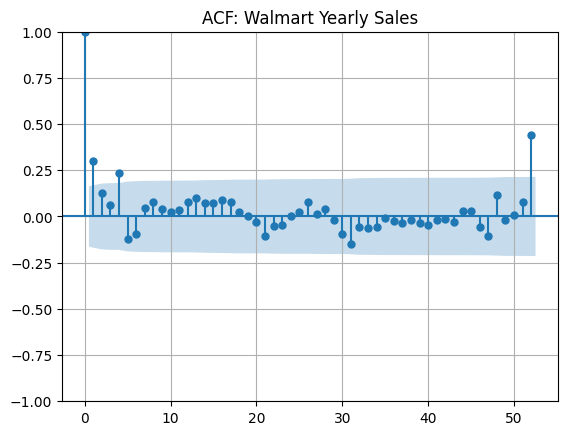

In [60]:
plot_acf(walmart_first_store, lags=52)
plt.title('ACF: Walmart Yearly Sales')
plt.grid(True)

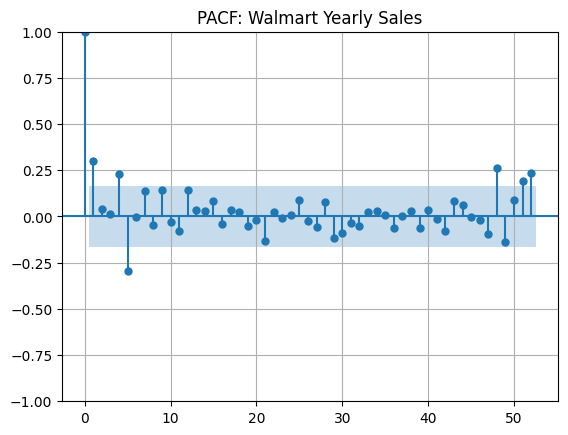

In [61]:
plot_pacf(walmart_first_store, lags=52)
plt.title('PACF: Walmart Yearly Sales')
plt.grid(True)

In [62]:
# ACF: There is not much correlation at first. 
# After a few lags, the correlation becomes stronger, 
# suggesting that past data has a significant influence.

# PACF: The sales data is strongly correlated with its immediate past values, 
# particularly at lag 1. After that, the correlation quickly diminishes, 
# suggesting short-term dependencies and limited long-term effects.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [63]:
walmart_first_store.index = pd.to_datetime(walmart_first_store.index)

In [64]:
print('Train set', walmart_first_store.shape[0]*0.9)
print('Test set', walmart_first_store.shape[0]*0.1)

# Train = 128, Test = 15, total = 143

Train set 128.70000000000002
Test set 14.3


In [65]:
# Split the data
train = walmart_first_store.iloc[:128]       
test = walmart_first_store.iloc[128:]    

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [66]:
adf_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(walmart_first_store)
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Used Lag:', usedlag)
print('Number of Observations:', nobs)

# Critical values from Dickey-Fuller distribution tables
print('\nCritical values:')
for key, value in critical_values.items():
    print(f'\t{key} : {value}')

ADF Statistic: -5.1021861451922845
p-value: 1.387778833075967e-05
Used Lag: 4
Number of Observations: 138

Critical values:
	1% : -3.47864788917503
	5% : -2.882721765644168
	10% : -2.578065326612056


---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [67]:
# Instanitate and fit

# Set frequency if it's weekly data
train = train.asfreq('W-FRI')

# Now fit the ARIMA model
model = ARIMA(train['Weekly_Sales'], order=(1, 0, 0))
model = model.fit()

# Print the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1710.923
Date:                Mon, 09 Dec 2024   AIC                           3427.846
Time:                        17:31:23   BIC                           3436.402
Sample:                    02-05-2010   HQIC                          3431.323
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.31e+04     67.488      0.000    1.51e+06     1.6e+06
ar.L1          0.3081      0.050      6.118      0.000       0.209       0.407
sigma2      2.397e+10      0.172   1.39e+11      0.000     2.4e+10     2.4e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               204.46
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.66e+25. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of **start** and **end** dates.

Generate and store predictions for the training and testing data.

In [68]:
y_pred = model.predict(start = 128, end = 142)

**Mean squared error**

Use the [mean_squared_error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html) function to identify the MSE on the testing data.

In [69]:
float(mean_squared_error(test['Weekly_Sales'], y_pred))

5188882502.605215

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

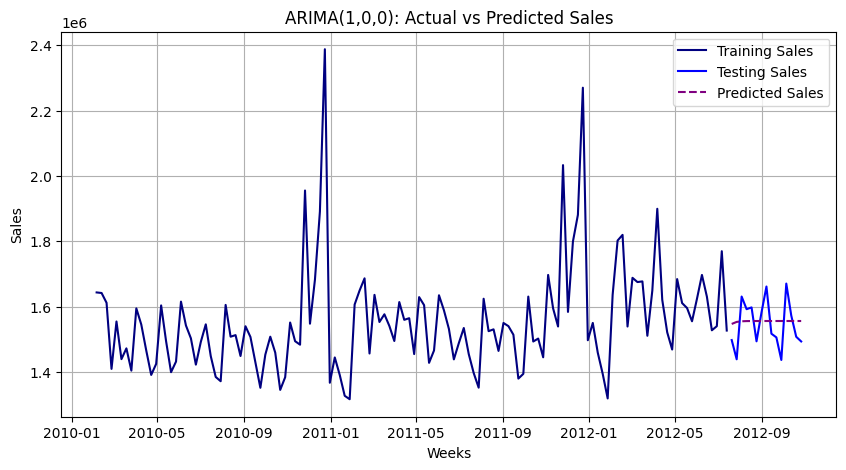

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Weekly_Sales'],c= 'navy', label = 'Training Sales')
plt.plot(test.index, test['Weekly_Sales'],c= 'blue', label = 'Testing Sales')
plt.plot(test.index, y_pred, c= 'purple', label = 'Predicted Sales', linestyle='--')
plt.title('ARIMA(1,0,0): Actual vs Predicted Sales')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [71]:
# It poorly predictions from AR(1) model

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [72]:
import warnings

# Avoid warning
warnings.filterwarnings("ignore", category=UserWarning, message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", category=UserWarning, message="Non-invertible starting MA parameters found")

In [73]:
# Now fit the ARIMA model
model = ARIMA(train['Weekly_Sales'], order=(2, 0, 2))
model = model.fit()

# Print the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1701.493
Date:                Mon, 09 Dec 2024   AIC                           3414.985
Time:                        17:31:26   BIC                           3432.097
Sample:                    02-05-2010   HQIC                          3421.938
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.38e+04     65.254      0.000    1.51e+06     1.6e+06
ar.L1         -1.0500      0.072    -14.590      0.000      -1.191      -0.909
ar.L2         -0.4778      0.066     -7.191      0.000      -0.608      -0.348
ma.L1          1.4604      0.072     20.411      0.000       1.320       1.601
ma.L2          0.9825      0.088     11.217      0.000       0.811       1.154
sigma2      2.279e+10      0.059   3.83e+11      0.000    2.28e+10    2.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                74.45
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.56e+26. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [74]:
y_pred = model.predict(start = 128, end = 142)

**Mean squared error**

Find the MSE of the testing data.

In [75]:
float(mean_squared_error(test['Weekly_Sales'], y_pred))

4617981609.121073

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

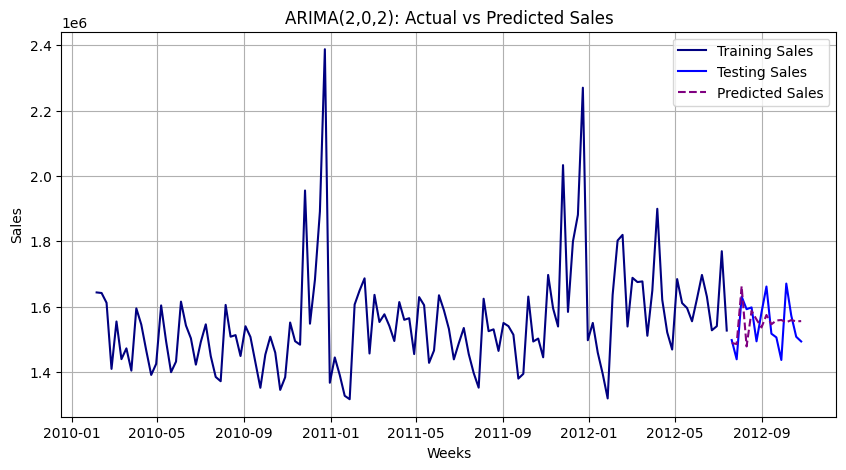

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Weekly_Sales'],c= 'navy', label = 'Training Sales')
plt.plot(test.index, test['Weekly_Sales'],c= 'blue', label = 'Testing Sales')
plt.plot(test.index, y_pred, c= 'purple', label = 'Predicted Sales', linestyle='--')
plt.title('ARIMA(2,0,2): Actual vs Predicted Sales')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [77]:
# A: It's look better than AR(1) but still not much accurate with actual.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [78]:
# Now fit the ARIMA model
model = ARIMA(train['Weekly_Sales'], order=(2, 1, 2))
model = model.fit()

# Print the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1707.922
Date:                Mon, 09 Dec 2024   AIC                           3425.845
Time:                        17:31:28   BIC                           3440.066
Sample:                    02-05-2010   HQIC                          3431.623
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.280     -1.494      0.135      -0.966       0.130
ar.L2          0.4121      0.101      4.100      0.000       0.215       0.609
ma.L1         -0.1075      0.278     -0.387      0.699      -0.651       0.436
ma.L2         -0.7808      0.229     -3.408      0.001      -1.230      -0.332
sigma2      2.948e+10   1.54e-11   1.91e+21      0.000    2.95e+10    2.95e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                69.87
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.71
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+37. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [79]:
y_pred = model.predict(start = 128, end = 142)

**Mean squared error**

Find the MSE on your testing data.

In [80]:
float(mean_squared_error(test['Weekly_Sales'], y_pred))

8383610284.38383

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

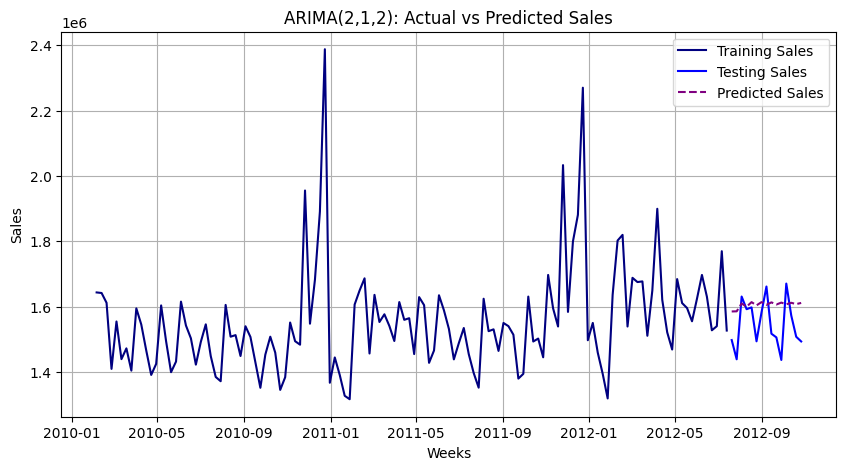

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Weekly_Sales'],c= 'navy', label = 'Training Sales')
plt.plot(test.index, test['Weekly_Sales'],c= 'blue', label = 'Testing Sales')
plt.plot(test.index, y_pred, c= 'purple', label = 'Predicted Sales', linestyle='--')
plt.title('ARIMA(2,1,2): Actual vs Predicted Sales')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [82]:
# A: It look like straight line, It's poorly predict after using d=2.

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [83]:
# Avoid warning
warnings.filterwarnings("ignore", category=UserWarning, message="Maximum Likelihood optimization failed to ")

In [84]:
# Now fit the ARIMA model
model = ARIMA(train['Weekly_Sales'], order=(52, 0, 2))
model = model.fit()

# Print the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                ARIMA(52, 0, 2)   Log Likelihood               -1642.484
Date:                Mon, 09 Dec 2024   AIC                           3396.969
Time:                        17:33:02   BIC                           3556.682
Sample:                    02-05-2010   HQIC                          3461.861
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.38e-07   6.55e+12      0.000    1.56e+06    1.56e+06
ar.L1          0.0625      0.147      0.426      0.670      -0.225       0.350
ar.L2          0.1232      0.151      0.814      0.416      -0.173       0.420
ar.L3         -0.1185      0.123     -0.963      0.335      -0.360       0.123
ar.L4          0.0978      0.104      0.937      0.349      -0.107       0.302
ar.L5         -0.0461      0.106     -0.433      0.665      -0.255       0.163
ar.L6         -0.0800      0.115     -0.698      0.485      -0.305       0.145
ar.L7          0.1467      0.096      1.525      0.127      -0.042       0.335
ar.L8         -0.0702      0.080     -0.881      0.379      -0.226       0.086
ar.L9          0.0441      0.098      0.450      0.652      -0.148       0.236
ar.L10         0.0334      0.084      0.397      0.691      -0.131       0.198
ar.L11        -0.0757      0.089     -0.846      0.397      -0.251       0.100
ar.L12         0.1475      0.094      1.575      0.115      -0.036       0.331
ar.L13        -0.0007      0.088     -0.007      0.994      -0.173       0.172
ar.L14         0.0019      0.092      0.021      0.984      -0.179       0.182
ar.L15         0.1039      0.078      1.339      0.181      -0.048       0.256
ar.L16        -0.0475      0.083     -0.575      0.565      -0.209       0.114
ar.L17         0.0613      0.084      0.728      0.466      -0.104       0.226
ar.L18         0.0229      0.088      0.260      0.795      -0.150       0.196
ar.L19        -0.0211      0.101     -0.208      0.835      -0.220       0.177
ar.L20         0.0526      0.085      0.622      0.534      -0.113       0.218
ar.L21        -0.0274      0.099     -0.276      0.783      -0.222       0.167
ar.L22         0.0335      0.115      0.291      0.771      -0.192       0.259
ar.L23         0.0076      0.116      0.065      0.948      -0.221       0.236
ar.L24        -0.0597      0.091     -0.658      0.510      -0.237       0.118
ar.L25         0.0560      0.105      0.531      0.595      -0.151       0.263
ar.L26        -0.0341      0.098     -0.347      0.729      -0.227       0.159
ar.L27         0.0047      0.110      0.043      0.966      -0.210       0.220
ar.L28         0.0551      0.094      0.584      0.559      -0.130       0.240
ar.L29        -0.0364      0.084     -0.434      0.664      -0.201       0.128
ar.L30         0.0182      0.130      0.140      0.888      -0.236       0.272
ar.L31        -0.0884      0.112     -0.788      0.431      -0.308       0.131
ar.L32         0.0005      0.104      0.005      0.996      -0.204       0.205
ar.L33         0.0351      0.113      0.310      0.756      -0.186       0.256
ar.L34        -0.0905      0.134     -0.674      0.500      -0.354       0.173
ar.L35         0.0554      0.126      0.441      0.659      -0.191       0.302
ar.L36        -0.0661      0.087     -0.764      0.445      -0.236       0.104
ar.L37        -0.0837      0.090     -0.929      0.353      -0.260       0.093
ar

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [85]:
y_pred = model.predict(start = 128, end = 142)

**Mean squared error**

Find the MSE on your testing data.

In [86]:
float(mean_squared_error(test['Weekly_Sales'], y_pred))

7950332720.437135

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

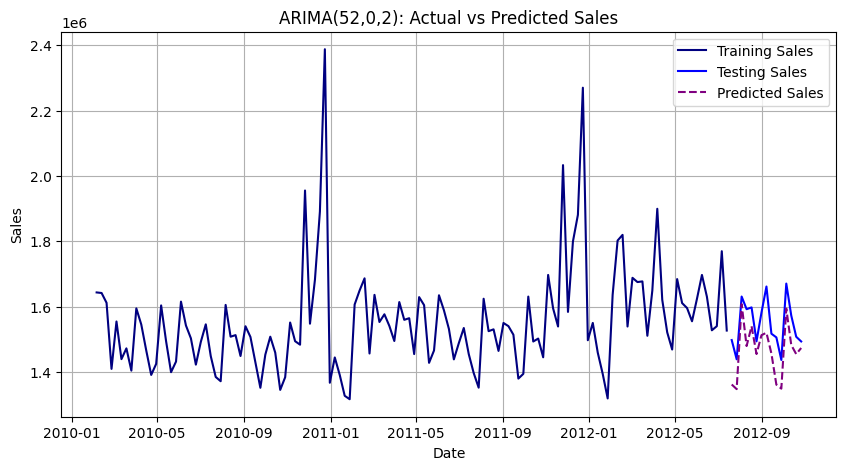

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Weekly_Sales'],c= 'navy', label = 'Training Sales')
plt.plot(test.index, test['Weekly_Sales'],c= 'blue', label = 'Testing Sales')
plt.plot(test.index, y_pred, c= 'purple', label = 'Predicted Sales', linestyle='--')
plt.title('ARIMA(52,0,2): Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [88]:
 # It predicts accurately at the start of the pattern but underestimates the actual values afterward.

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [89]:
# Avoid warning
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters")

In [90]:
sarima = SARIMAX(train['Weekly_Sales'], order = (2, 0, 2), seasonal_order = (1, 1, 1, 52))
sarima = sarima.fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         Weekly_Sales   No. Observations:                  128
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 52)   Log Likelihood                -953.894
Date:                              Mon, 09 Dec 2024   AIC                           1921.787
Time:                                      17:37:48   BIC                           1938.102
Sample:                                  02-05-2010   HQIC                          1928.308
                                       - 07-13-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1907      0.421     -0.453      0.651      -1.017       0.635
ar.L2         -0.6006      0.463     -1.297      0.195      -1.508       0.307
ma.L1          0.2136      0.451      0.474      0.636      -0.670       1.098
ma.L2          0.5081      0.517      0.982      0.326      -0.506       1.522
ar.S.L52       0.9908      0.148      6.706      0.000       0.701       1.280
ma.S.L52      -0.9718      0.251     -3.865      0.000      -1.465      -0.479
sigma2      4.971e+09   1.02e-10   4.88e+19      0.000    4.97e+09    4.97e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):                 4.49
Prob(Q):                              0.36   Prob(JB):                         0.11
Heteroskedasticity (H):               1.94   Skew:                             0.28
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+35. Standard errors may be unstable.
"""

In [91]:
y_pred = sarima.predict(start = 128, end = 142)

In [92]:
float(mean_squared_error(test['Weekly_Sales'], y_pred))

1893020122.24457

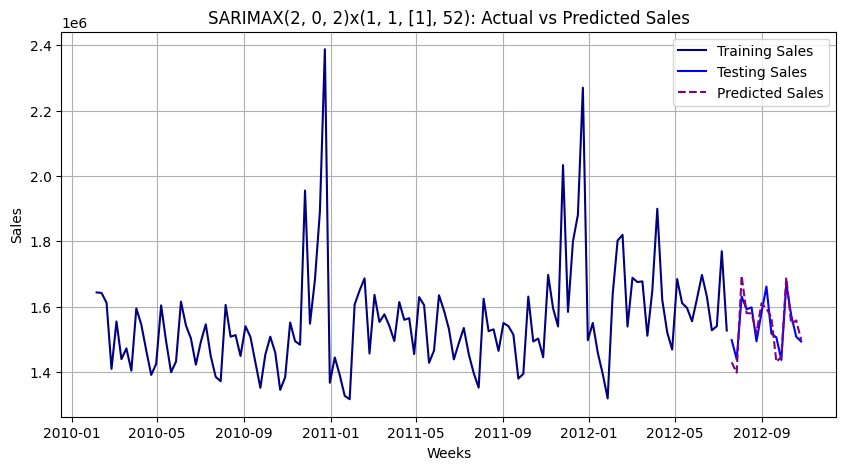

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Weekly_Sales'],c= 'navy', label = 'Training Sales')
plt.plot(test.index, test['Weekly_Sales'],c= 'blue', label = 'Testing Sales')
plt.plot(test.index, y_pred, c= 'purple', label = 'Predicted Sales', linestyle='--')
plt.title('SARIMAX(2, 0, 2)x(1, 1, [1], 52): Actual vs Predicted Sales')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
# The SARIMA model performs the best compared to earlier models, 
# with the lowest MSE and predictions that closely align with the actual values.